# __Boosting__

## 1. Import necessary libraries

In [31]:
import numpy as np # linear algebra
import pandas as pd  # data management (dataframes)
import matplotlib.pyplot as plt
import seaborn as sns  # plotting

# Machine learning libraries
import math
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree, export_text

# mltools (custom library)
from mltools import classification_tools as CT
from mltools import model_tools as MT
from mltools import regression_tools as RT

## 2. Load data as a Pandas DataFrame

In [3]:
path_irrad = "../data/G07A_DATOS_IRRAD.csv"
df_orig_irrad = pd.read_csv(path_irrad)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_irrad['FECHA'] = pd.to_datetime(df_orig_irrad['FECHA'], format='%Y-%m-%d')

s = df_orig_irrad.loc[:,'FECHA']
df_orig_irrad['FECHA'] =  s.dt.date

In [4]:
path_util = "../data/G07A_DATOS_UTIL.csv"
df_orig_util = pd.read_csv(path_util)

# Parse the date (string) for it to be a datetime with format yyyy/mm/dd
df_orig_util['FECHA'] = pd.to_datetime(df_orig_util['FECHA'], format='%Y-%m-%d')

s = df_orig_util.loc[:,'FECHA']
df_orig_util['FECHA'] =  s.dt.date

In [12]:
# Unimos ambos dataframes
df = pd.merge(df_orig_irrad, df_orig_util, on=['FECHA', 'ANNO', 'MES', 'DIA', 'DIASEM'] , how='inner')

# Separamos el DataFrame en partes según la descripción
fecha_df = df[['ANNO', 'MES', 'DIA', 'DIASEM']]
irrad_df = df.filter(regex='^IRRAD')
util_df = df.filter(regex='^UTIL')

# Transformamos los DataFrames de irradiación y utilización
irrad_melted = irrad_df.melt(var_name='FranjaHoraria', value_name='Irradiacion')
util_melted = util_df.melt(var_name='FranjaHoraria', value_name='Utilizacion')

# Ajustamos la franja horaria para extracción
irrad_melted['FranjaHoraria'] = irrad_melted['FranjaHoraria'].str.extract('(\d+)')
util_melted['FranjaHoraria'] = util_melted['FranjaHoraria'].str.extract('(\d+)')

# Repetimos fecha_df para cada franja horaria (8 veces)
fecha_expanded = pd.concat([fecha_df]*irrad_df.shape[1], ignore_index=True)
df_repetido = fecha_expanded.reset_index(drop=True)
irrad_melted = irrad_melted.reset_index(drop=True)
util_melted = util_melted.reset_index(drop=True)

# Extraemos las columnas específicas y resetear sus índices
irrad_serie = irrad_melted['Irradiacion'].reset_index(drop=True)
franja_serie = irrad_melted['FranjaHoraria'].reset_index(drop=True)  # Incluir la columna 'franja horaria'
util_serie = util_melted['Utilizacion'].reset_index(drop=True)

# Unimos los DataFrames/series
df_final = pd.concat([df_repetido, franja_serie, irrad_serie, util_serie], axis=1)

In [13]:
# Convertimos 'FranjaHoraria' a integer y ordenamos el df
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype(int)
df_final = df_final.sort_values(by=['ANNO', 'MES', 'DIA', 'FranjaHoraria'])

# Calculamos los lags de irradiación
df_final['Irradiacion_lag1'] = df_final['Irradiacion'].shift(1)
df_final['Irradiacion_lag2'] = df_final['Irradiacion'].shift(2)
df_final['Irradiacion_lag8'] = df_final['Irradiacion'].shift(8) # un día antes
df_final['Irradiacion_lag365'] = df_final['Irradiacion'].shift(365*8) # un año antes

# Calculamos los lags de utilización
df_final['Utilizacion_lag1'] = df_final['Utilizacion'].shift(1)
df_final['Utilizacion_lag2'] = df_final['Utilizacion'].shift(2)
df_final['Utilizacion_lag8'] = df_final['Utilizacion'].shift(8) # un día antes
df_final['Utilizacion_lag365'] = df_final['Utilizacion'].shift(365*8) # un año antes

# Eliminamos los valores nulos
df_final = df_final.dropna()

# Cambiamos ANNO, MES, DIA, DIASEM y FranjaHoraria a categóricos
df_final['ANNO'] = df_final['ANNO'].astype('category')
df_final['MES'] = df_final['MES'].astype('category')
df_final['DIA'] = df_final['DIA'].astype('category')
df_final['DIASEM'] = df_final['DIASEM'].astype('category')
df_final['FranjaHoraria'] = df_final['FranjaHoraria'].astype('category')

In [24]:
# Inputs of the model
INPUTS_NUM = ['Irradiacion', 'Irradiacion_lag1', 'Irradiacion_lag2', 'Irradiacion_lag8', 'Irradiacion_lag365', 'Utilizacion_lag1', 'Utilizacion_lag2', 'Utilizacion_lag8', 'Utilizacion_lag365']
INPUTS_CAT = ['ANNO', 'MES', 'DIA', 'DIASEM', 'FranjaHoraria'] # Weekday is numerical in this case - Intervention variables
INPUTS = INPUTS_NUM + INPUTS_CAT
OUTPUT = 'Utilizacion'

#numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
#categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

# We have categorical inputs with many classes. We will create dummy variables automatically after
X = df_final[INPUTS]
y = df_final[OUTPUT]

# Divide the data into training and test sets 
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                   test_size=0.2,  #percentage of test data
                                                   random_state=999) #seed for replication

# Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['Utilizacion'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['Utilizacion'] = y_test

# Print the sizes of the training and test datasets
print("Size of the training set:", dfTR_eval.shape)
print("Size of the test set:", dfTS_eval.shape)

Size of the training set: (11692, 15)
Size of the test set: (2924, 15)


## 3. Fit the models

#### a) Single Regression Tree

In [26]:
# Inputs of the model
INPUTS_DT = INPUTS

# grid in min_impurity x min_samples_leaf x min_samples_split
param = {'DT__min_impurity_decrease': np.arange(0, 0.001 * np.var(y_train),0.001), # Minimum impurity to decrease in each split
         'DT__min_samples_leaf': np.arange(1,10,1), # Minimum number of obs in a terminal node
         'DT__min_samples_split':  np.arange(1,10,1)} # Minimum number of obs in node to keep cutting

# param = {'DT__min_impurity_decrease': np.arange(0,0.05,0.005)} # Minimum entropy to decrease in each split

pipe = Pipeline(steps=[('DT', DecisionTreeRegressor(criterion='squared_error',  # impurity measure: variance reduction
                                                     random_state=150))]) # For replication
                                                     
# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
single_reg_tree_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       cv=nFolds) # Number of Folds 
                       
single_reg_tree_fit.fit(X_train, y_train) # Search in grid


c:\Users\Minerva\anaconda3\envs\ML2\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
90 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Minerva\anaconda3\envs\ML2\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Minerva\anaconda3\envs\ML2\Lib\site-packages\sklearn\base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\Minerva\anaconda3\envs\ML2\Lib\site-packages\sklearn\pipeline.py", l

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('DT',
                                        DecisionTreeRegressor(random_state=150))]),
             n_jobs=-1,
             param_grid={'DT__min_impurity_decrease': array([0.]),
                         'DT__min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'DT__min_samples_split': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [28]:
# Show the best grid parameter combination found by CV
single_reg_tree_fit.best_estimator_['DT'].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 150,
 'splitter': 'best'}

In [50]:
# Predict
y_train_est = single_reg_tree_fit.best_estimator_['DT'].predict(X_train)
y_test_est = single_reg_tree_fit.best_estimator_['DT'].predict(X_test)
num_nodes = single_reg_tree_fit.best_estimator_['DT'].tree_.node_count
# Obtain a report of the model based on predictions
dfTR_eval['DT_pred'] = y_train_est
dfTS_eval['DT_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['DT_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['DT_pred']))

Training MAE: 0.010256035194095913
Test MAE: 0.016525688289265983
Training RMSE: 0.019837568229661554
Test RMSE: 0.031931721318362194
Training R2: 0.9706460139734515
Test R2: 0.9216024435164134


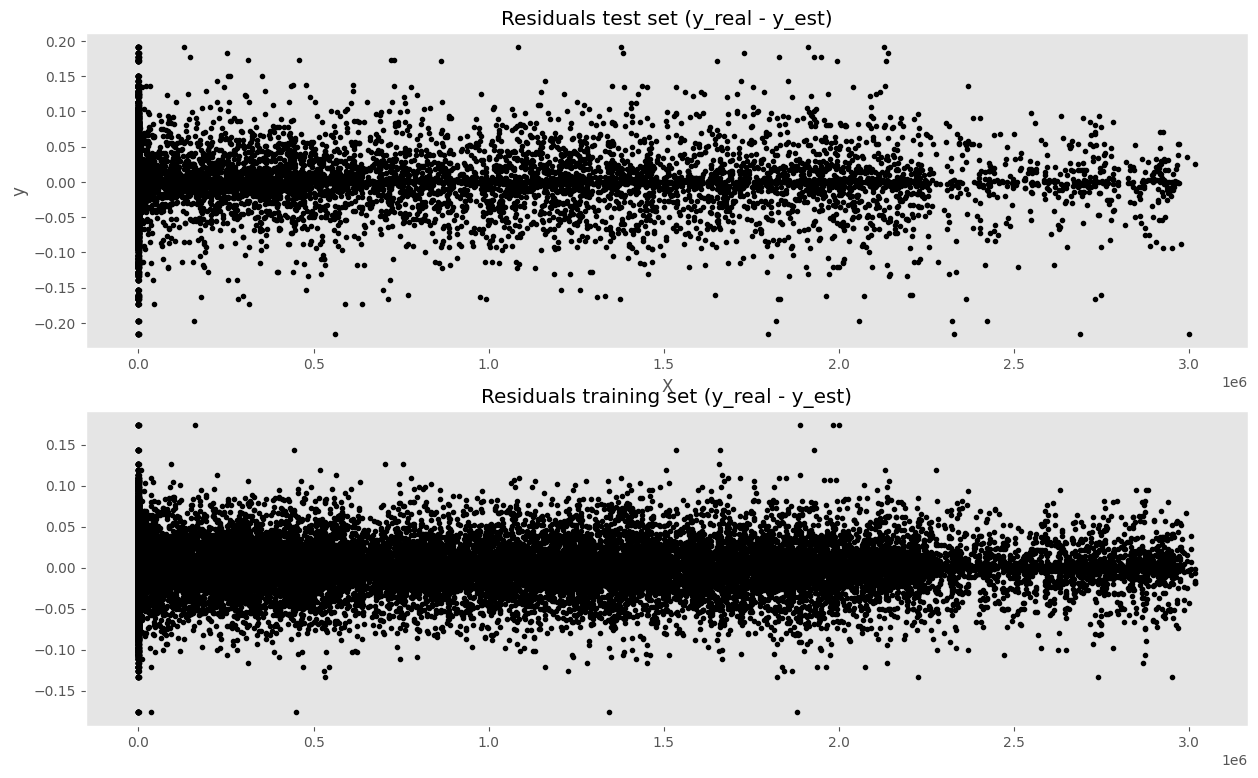

In [41]:
# Plot residuals

plt.figure(figsize=(15, 9))

plt.subplot(2,1,2)
plt.plot(X_train, y_train - y_train_est, '.', color = 'black')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(2,1,1)
plt.plot(X_test, y_test - y_test_est, '.', color = 'black')
plt.title(f'Residuals test set (y_real - y_est)')
plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.show()

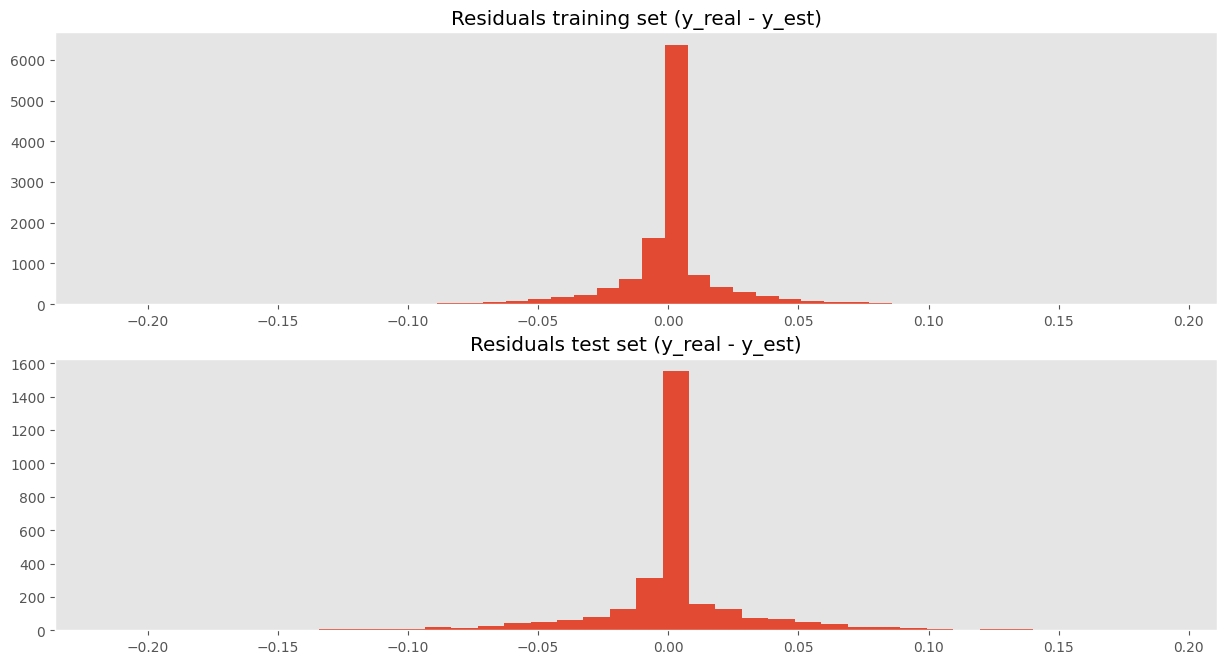

In [46]:
# Histogram of residuals

plt.figure(figsize=(15, 12))

ax=plt.subplot(3,1,2)
plt.hist(y_train - y_train_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(3,1,3, sharex = ax)
plt.hist(y_test - y_test_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals test set (y_real - y_est)')
plt.show()

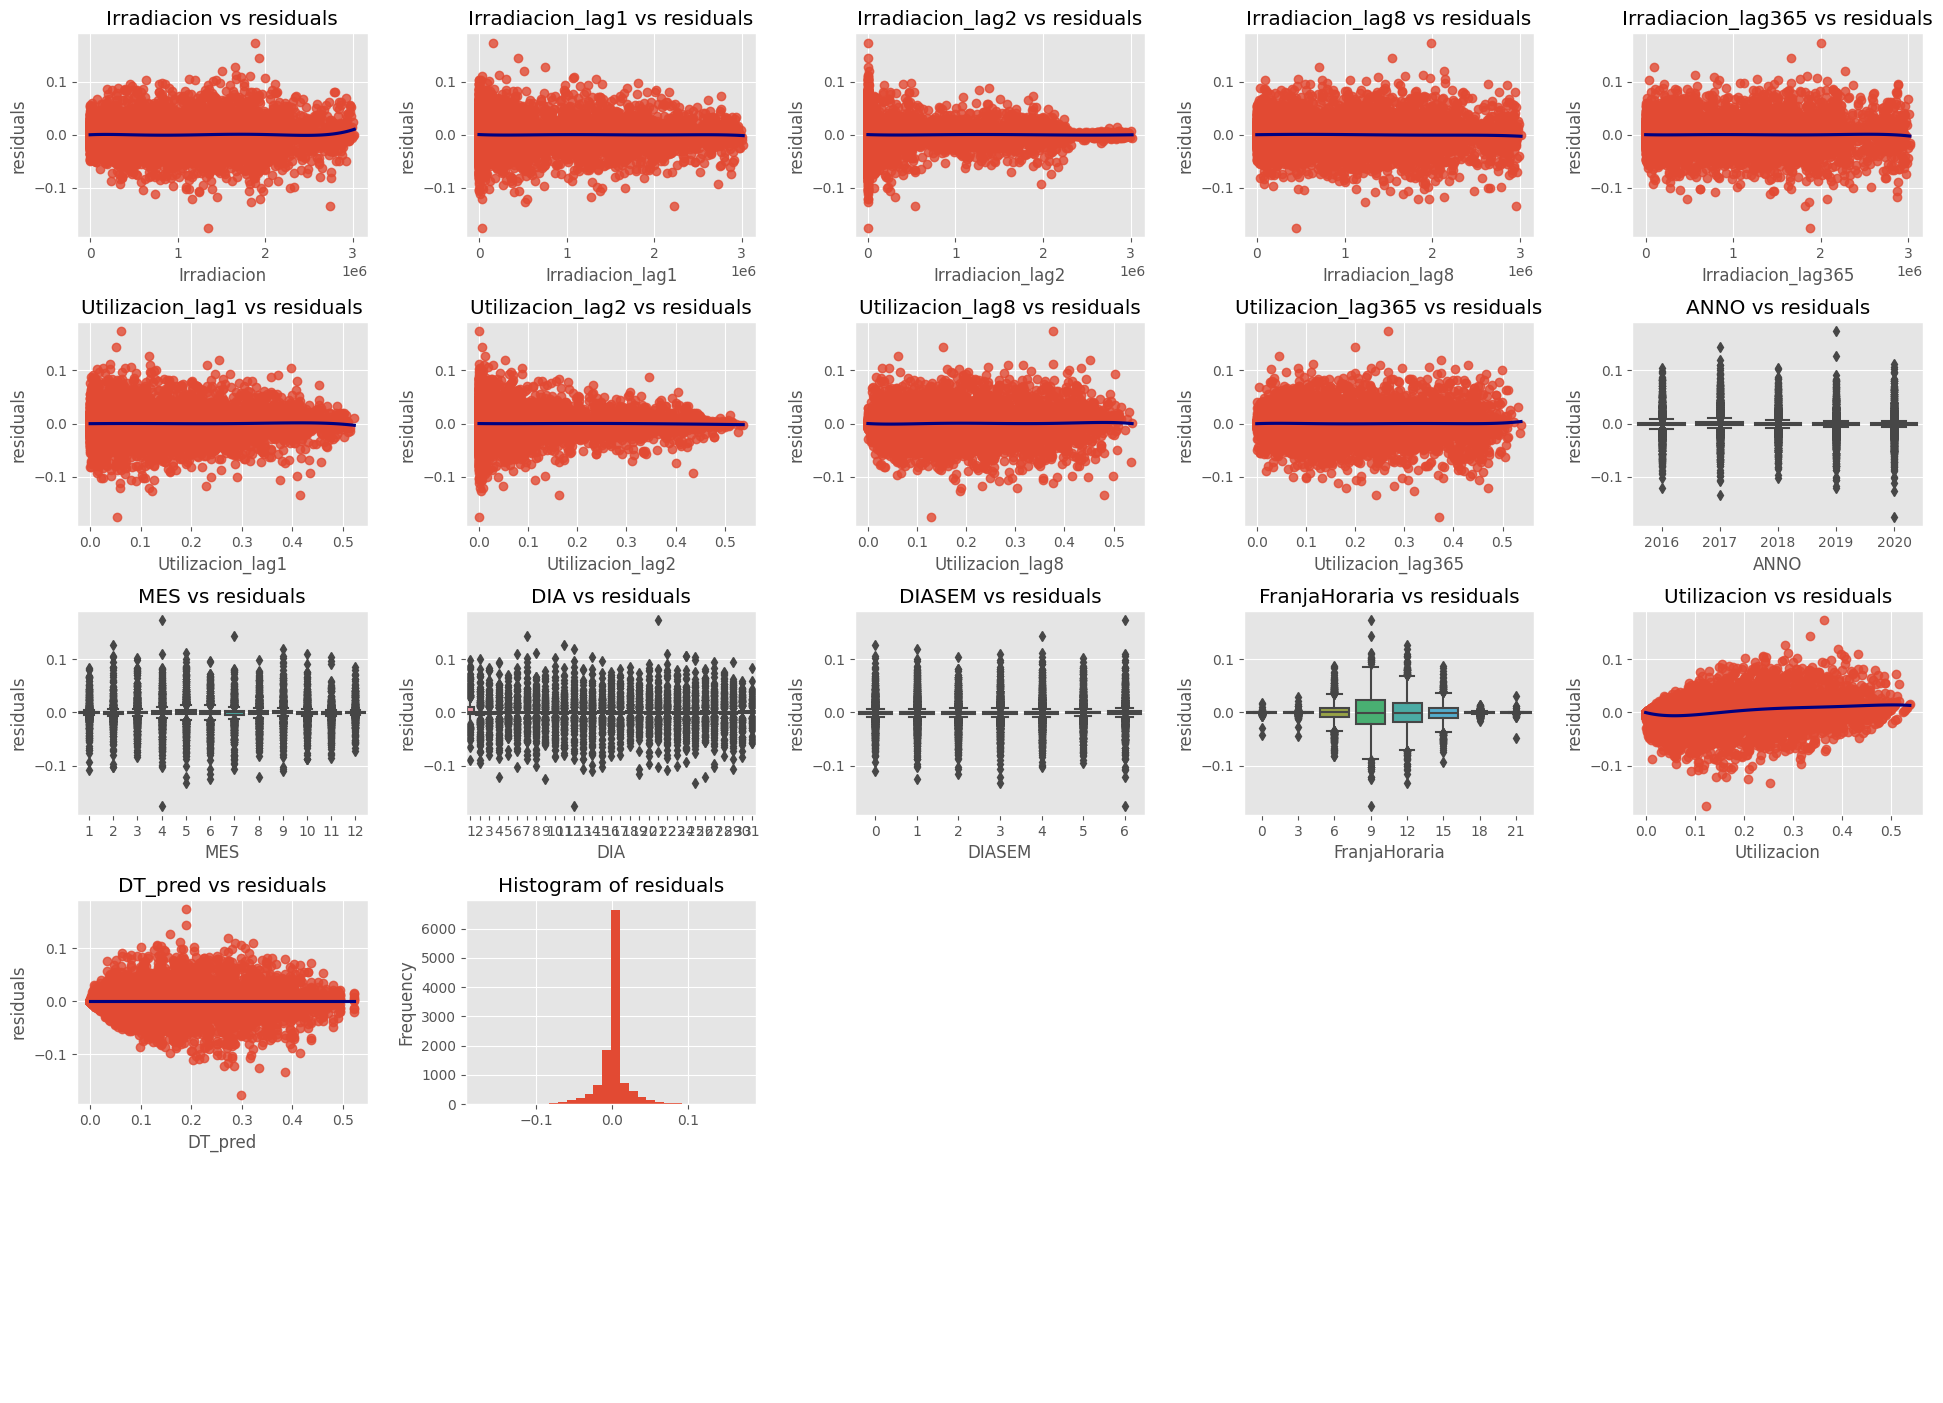

In [45]:
# Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'DT_pred', 'Utilizacion', figsize=[20,15])

#### b) AdaBoost

In [48]:
n_estimators=5000
max_depth = 4
min_impurity_decrease =  0.001 * np.var(y_train)
AdaBoost_reg_tree_fit = AdaBoostRegressor(
                                DecisionTreeRegressor(max_depth=max_depth,
                                                      min_impurity_decrease=min_impurity_decrease), 
                                n_estimators=n_estimators,

                                random_state=999)

AdaBoost_reg_tree_fit.fit(X_train, y_train)
AdaBoost_reg_tree_fit.get_params()

{'base_estimator': 'deprecated',
 'estimator__ccp_alpha': 0.0,
 'estimator__criterion': 'squared_error',
 'estimator__max_depth': 4,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 1.3406326245115968e-05,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__random_state': None,
 'estimator__splitter': 'best',
 'estimator': DecisionTreeRegressor(max_depth=4, min_impurity_decrease=1.3406326245115968e-05),
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 5000,
 'random_state': 999}

In [51]:
# Predict
y_train_est = AdaBoost_reg_tree_fit.predict(X_train)
y_test_est = AdaBoost_reg_tree_fit.predict(X_test)
# Obtain a report of the model based on predictions
dfTR_eval['AB_pred'] = y_train_est
dfTS_eval['AB_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['AB_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['AB_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['AB_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['AB_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['AB_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['AB_pred']))

Training MAE: 0.05084897318095278
Test MAE: 0.05079836361173569
Training RMSE: 0.05456078226808624
Test RMSE: 0.05457497952019379
Training R2: 0.7779496852995003
Test R2: 0.7709949661651334


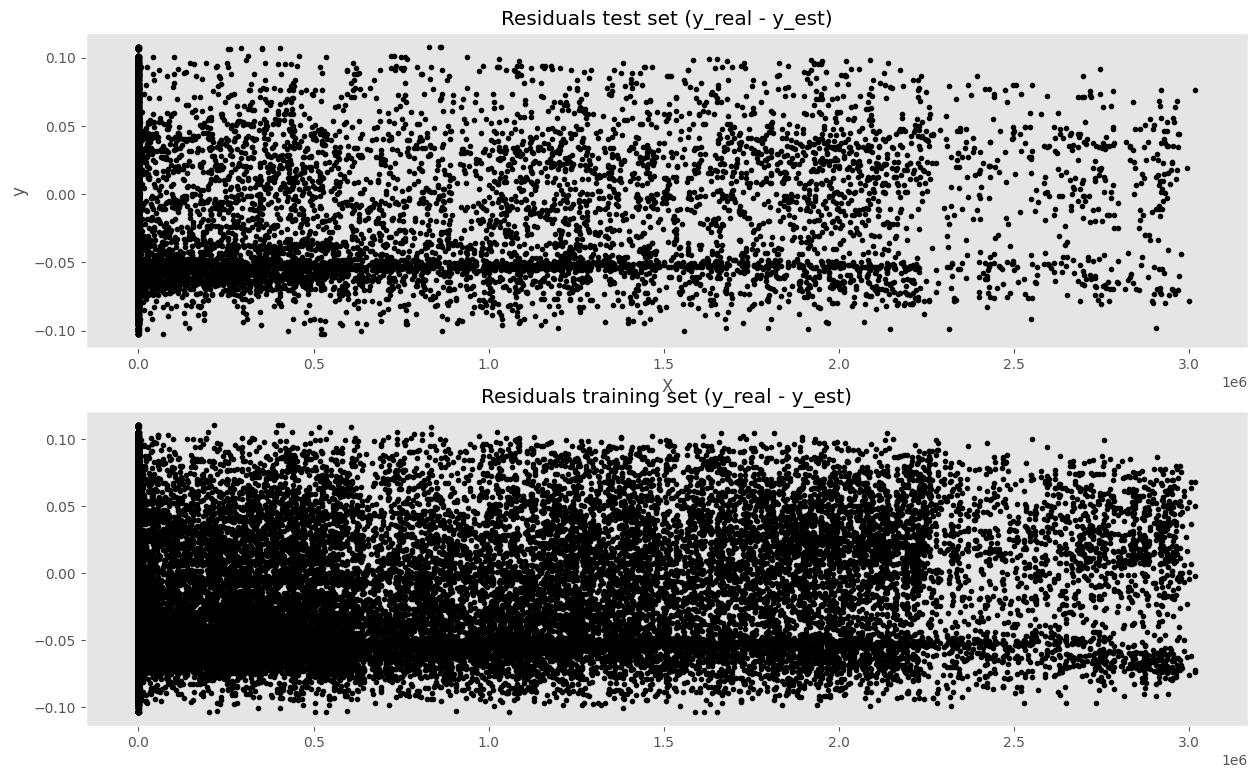

In [52]:
# Plot residuals

plt.figure(figsize=(15, 9))

plt.subplot(2,1,2)
plt.plot(X_train, y_train - y_train_est, '.', color = 'black')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(2,1,1)
plt.plot(X_test, y_test - y_test_est, '.', color = 'black')
plt.title(f'Residuals test set (y_real - y_est)')
plt.grid()
plt.xlabel('X')
plt.ylabel('y')
plt.show()

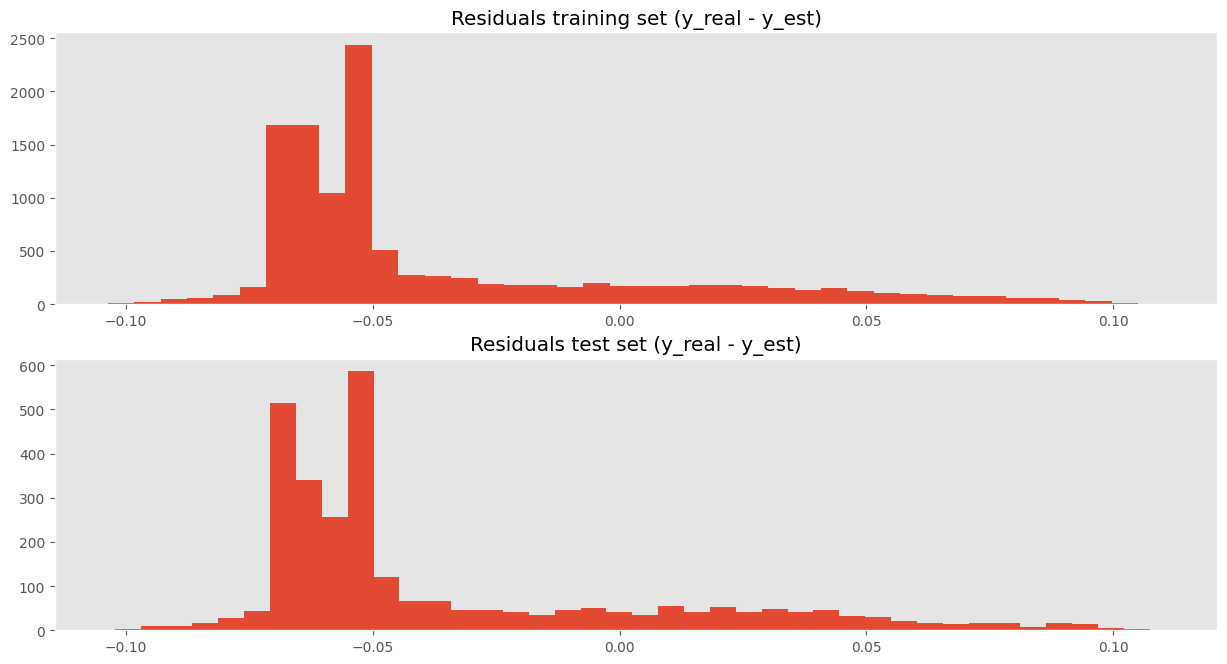

In [53]:
# Histogram of residuals

plt.figure(figsize=(15, 12))

ax=plt.subplot(3,1,2)
plt.hist(y_train - y_train_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(3,1,3, sharex = ax)
plt.hist(y_test - y_test_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals test set (y_real - y_est)')
plt.show()

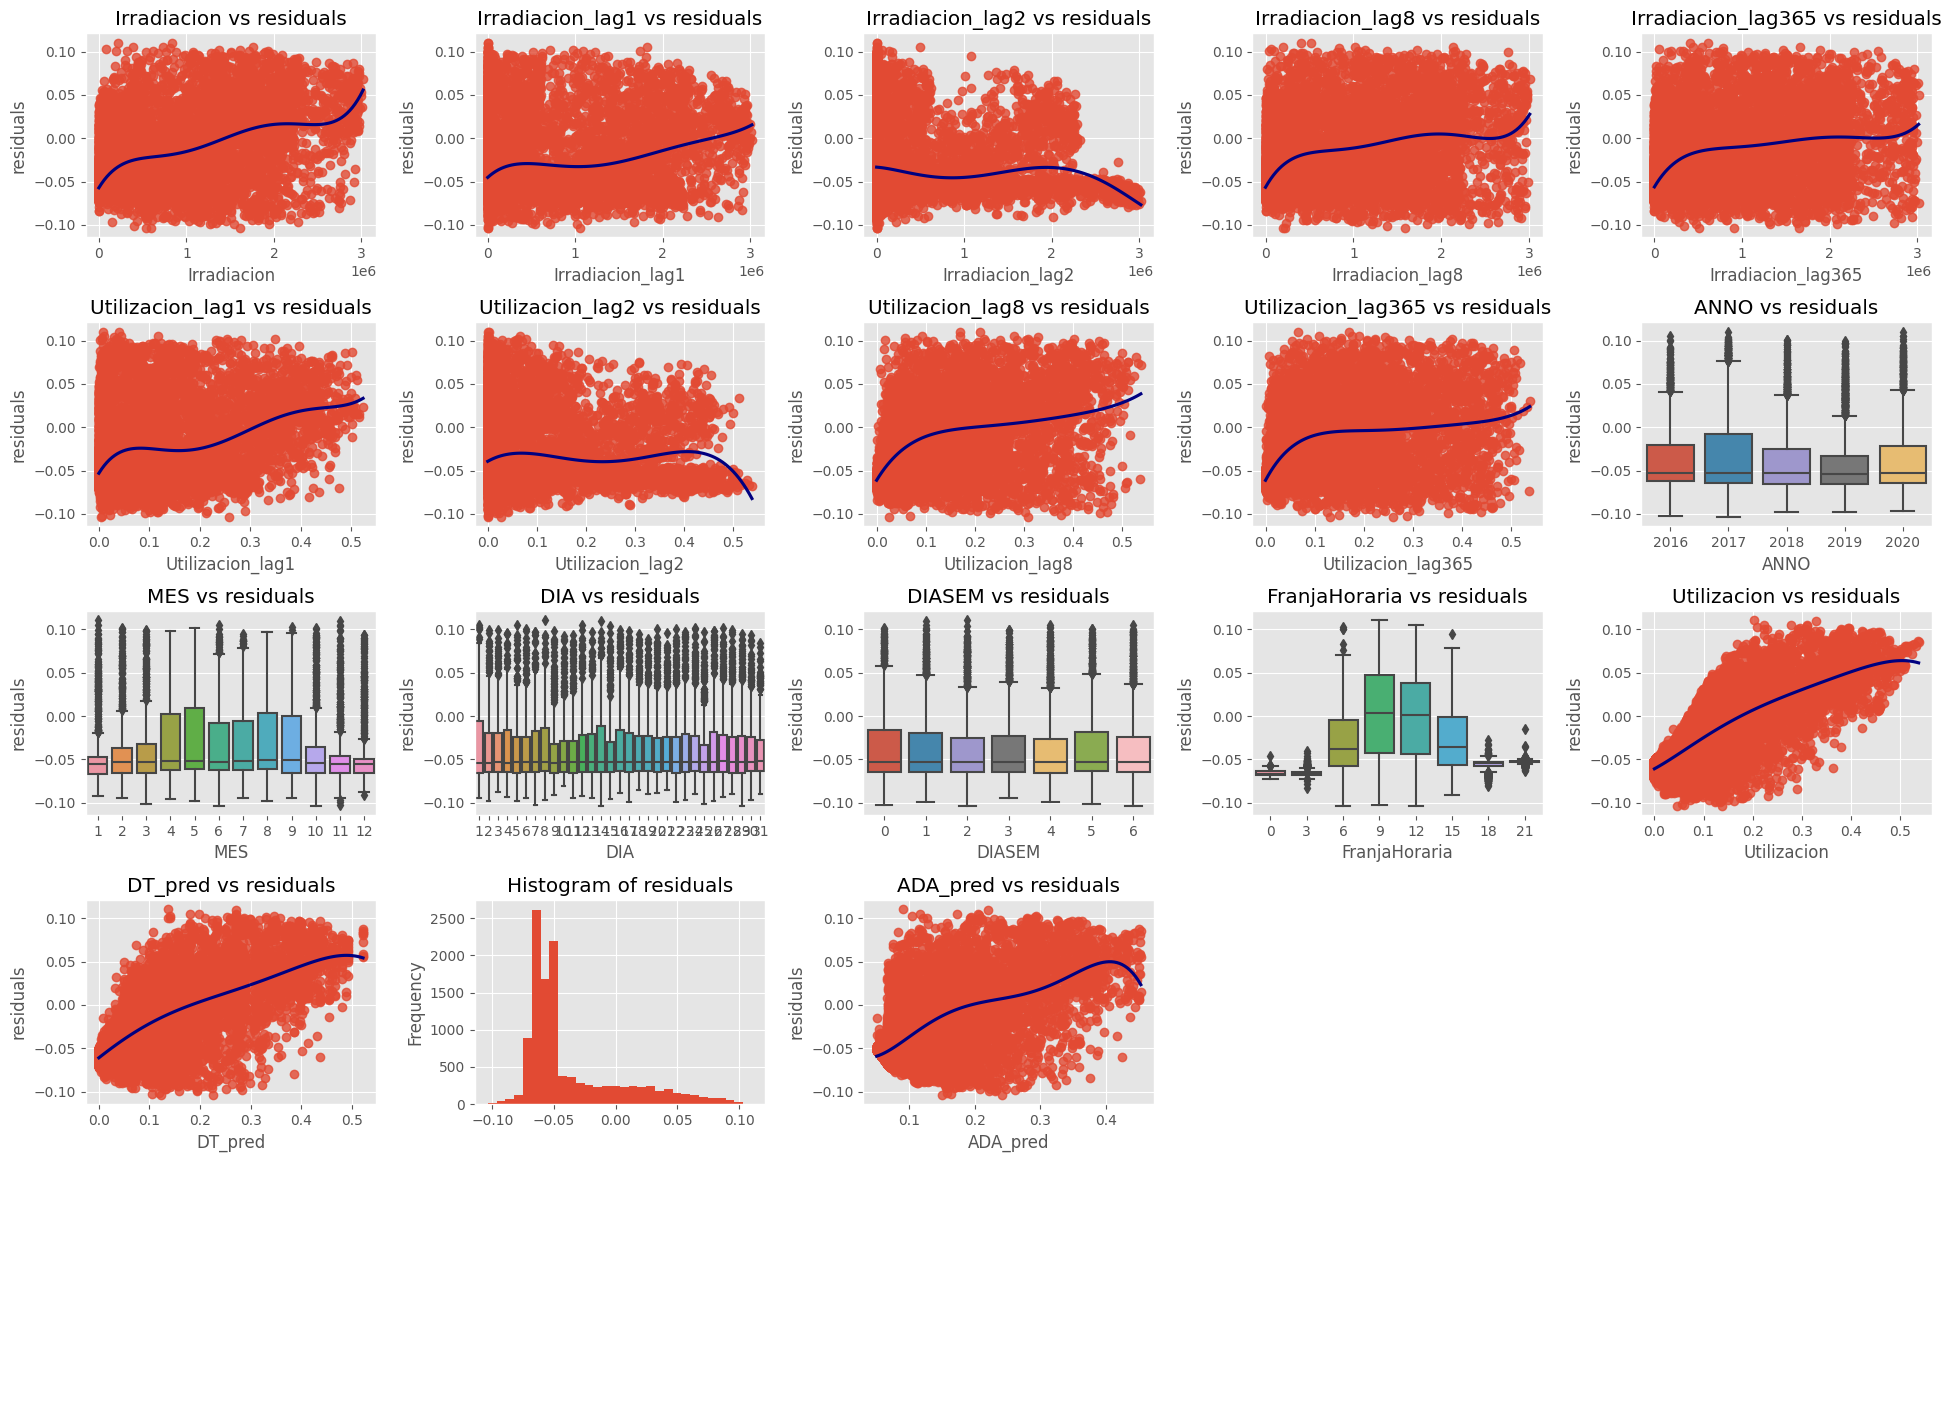

In [54]:
# Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'AB_pred', 'Utilizacion', figsize=[20,15])

##### c) Gradient boosting

In [55]:
number_estimators = 5000
learning_rate = 1.0
max_depth = 1
min_impurity_decrease =  0.001 * np.var(y_train)

GB_reg_estim = GradientBoostingRegressor(n_estimators=number_estimators,
                                            learning_rate = learning_rate,
                                            max_depth = max_depth,
                                            max_features = 1.0, # 'auto', ‘sqrt’, ‘log2’, int or float, default=None
                                            loss = 'squared_error',  
                                            min_impurity_decrease = min_impurity_decrease,  
                                            min_samples_split=2, # Minimum number of obs in node to keep cutting
                                            min_samples_leaf=1, # Minimum number of obs in a terminal node  
                                            random_state=0)

GB_reg_estim.fit(X_train, y_train)

# see all the params
GB_reg_estim.get_params() 

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 1.0,
 'loss': 'squared_error',
 'max_depth': 1,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 1.3406326245115968e-05,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5000,
 'n_iter_no_change': None,
 'random_state': 0,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [56]:
# Predict
y_train_est = GB_reg_estim.predict(X_train)
y_test_est = GB_reg_estim.predict(X_test)
# Obtain a report of the model based on predictions
dfTR_eval['GB_pred'] = y_train_est
dfTS_eval['GB_pred'] = y_test_est

# Training and test MAE - Mean Absolute error
print('Training MAE:', mean_absolute_error(dfTR_eval['Utilizacion'], dfTR_eval['GB_pred']))
print('Test MAE:', mean_absolute_error(dfTS_eval['Utilizacion'], dfTS_eval['GB_pred']))
# Training and test RMSE - Root Mean Square Error
print('Training RMSE:', math.sqrt(mean_squared_error(dfTR_eval['Utilizacion'], dfTR_eval['GB_pred'])))
print('Test RMSE:', math.sqrt(mean_squared_error(dfTS_eval['Utilizacion'], dfTS_eval['GB_pred'])))
# Training and test r^2 
print('Training R2:', r2_score(dfTR_eval['Utilizacion'], dfTR_eval['GB_pred']))
print('Test R2:', r2_score(dfTS_eval['Utilizacion'], dfTS_eval['GB_pred']))

Training MAE: 0.01692137638223682
Test MAE: 0.019959158807411777
Training RMSE: 0.026157277445281842
Test RMSE: 0.031583008056311604
Training R2: 0.9489641568585038
Test R2: 0.9233053891465581


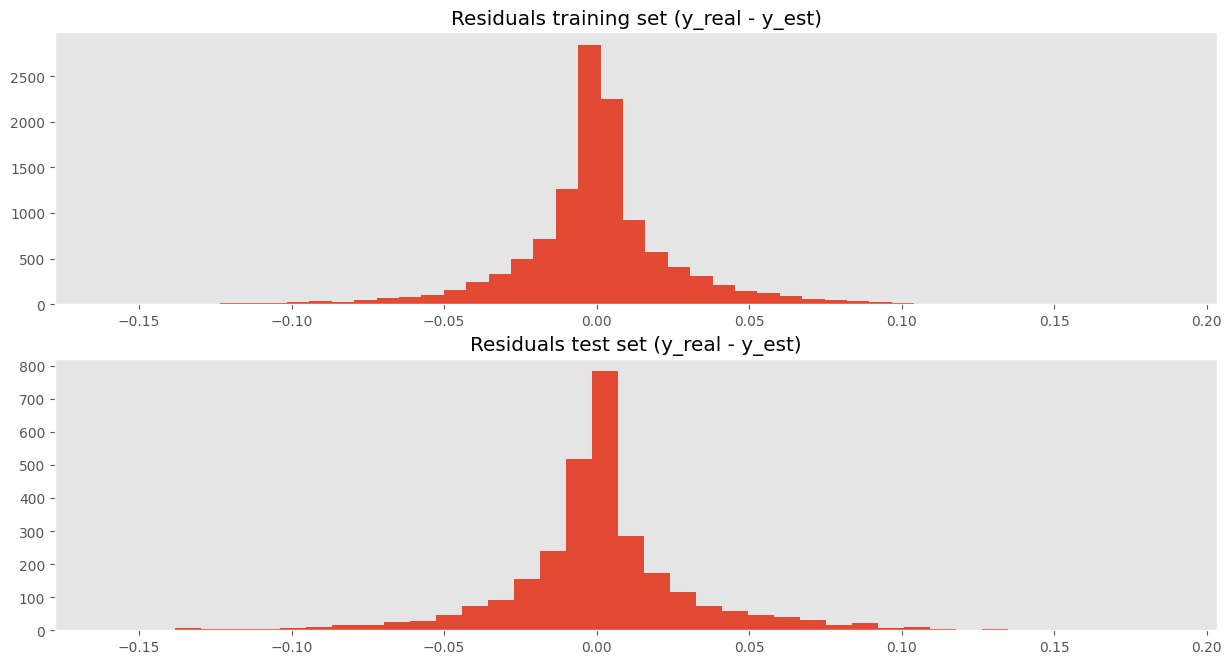

In [57]:
# Histogram of residuals

plt.figure(figsize=(15, 12))

ax=plt.subplot(3,1,2)
plt.hist(y_train - y_train_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals training set (y_real - y_est)')

plt.subplot(3,1,3, sharex = ax)
plt.hist(y_test - y_test_est, bins = 40, label='Residuals training set')
plt.grid()
plt.title(f'Residuals test set (y_real - y_est)')
plt.show()

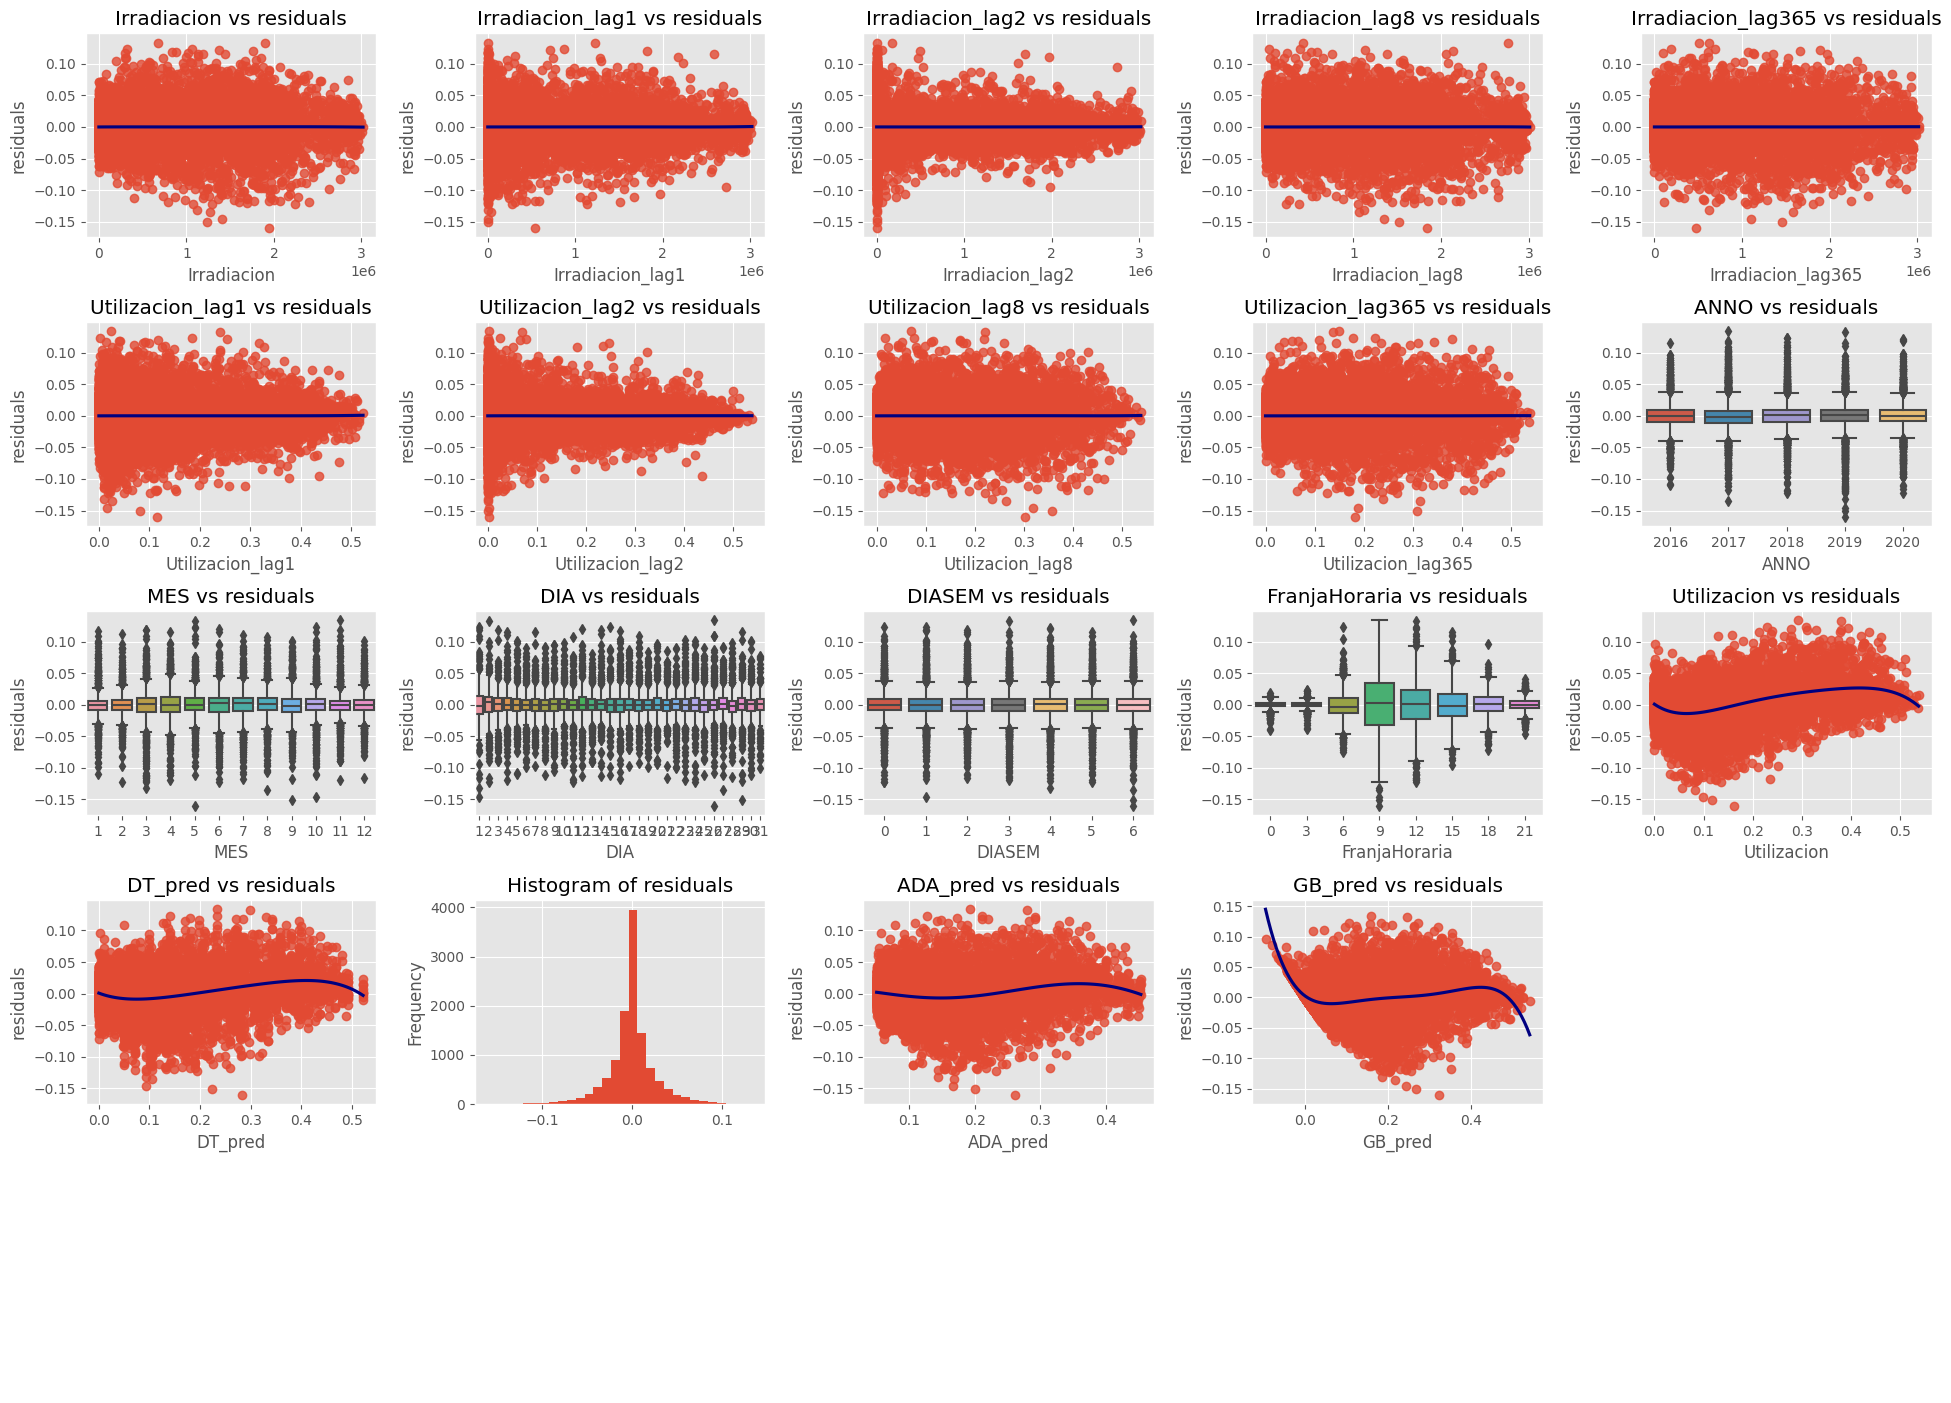

In [58]:
# Analysis of residuals
RT.plotModelDiagnosis(dfTR_eval, 'GB_pred', 'Utilizacion', figsize=[20,15])